GOES Aircraft Example
=====================

This example plots the most recent GOES-16 data with an overlay of the current
position of the NCAR C130 research aircraft. It also demonstrates projecting
vectors into map coordinates and matplotlib marker manipulation.

In [1]:
from datetime import datetime
import json
import urllib.request

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import patheffects
import matplotlib.pyplot as plt
import metpy  # noqa: F401
import metpy.calc as mpcalc
from metpy.plots.ctables import registry
from metpy.units import units
import numpy as np
from siphon.catalog import TDSCatalog
import xarray as xr
from xarray.backends import NetCDF4DataStore

In [3]:
def get_plane_data():
    """Get JSON data from NCAR aircraft."""
    endpoint_url = 'https://www.eol.ucar.edu/flight_data/C130/position.json'
    with urllib.request.urlopen(endpoint_url) as f:
        jstring = f.read()
    payload = json.loads(jstring.decode('utf-8'))
    data = {'latitude': float(payload['lat']),
            'longitude': float(payload['lon']),
            'altitude': float(payload['alt']),
            'heading': float(payload['head']),
            'time': payload['timestamp']}
    return data

In [4]:
def get_goes_image(date=datetime.utcnow(), channel=8, region='CONUS'):
    """Return dataset of GOES-16 data."""
    cat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/'
                     'CloudAndMoistureImagery/{}/Channel{:02d}/{:%Y%m%d}/'
                     'catalog.xml'.format(region, channel, date))

    ds = cat.datasets[-1]  # Get most recent dataset
    ds = ds.remote_access(service='OPENDAP')
    ds = NetCDF4DataStore(ds)
    ds = xr.open_dataset(ds)
    return ds

In [5]:
ds = get_goes_image()
data = get_plane_data()

In [6]:
# Parse out the projection data from the satellite file
dat = ds.metpy.parse_cf('Sectorized_CMI')
proj = dat.metpy.cartopy_crs

In [7]:
# Pull out what we need from the GOES netCDF file
x = dat['x']
y = dat['y']

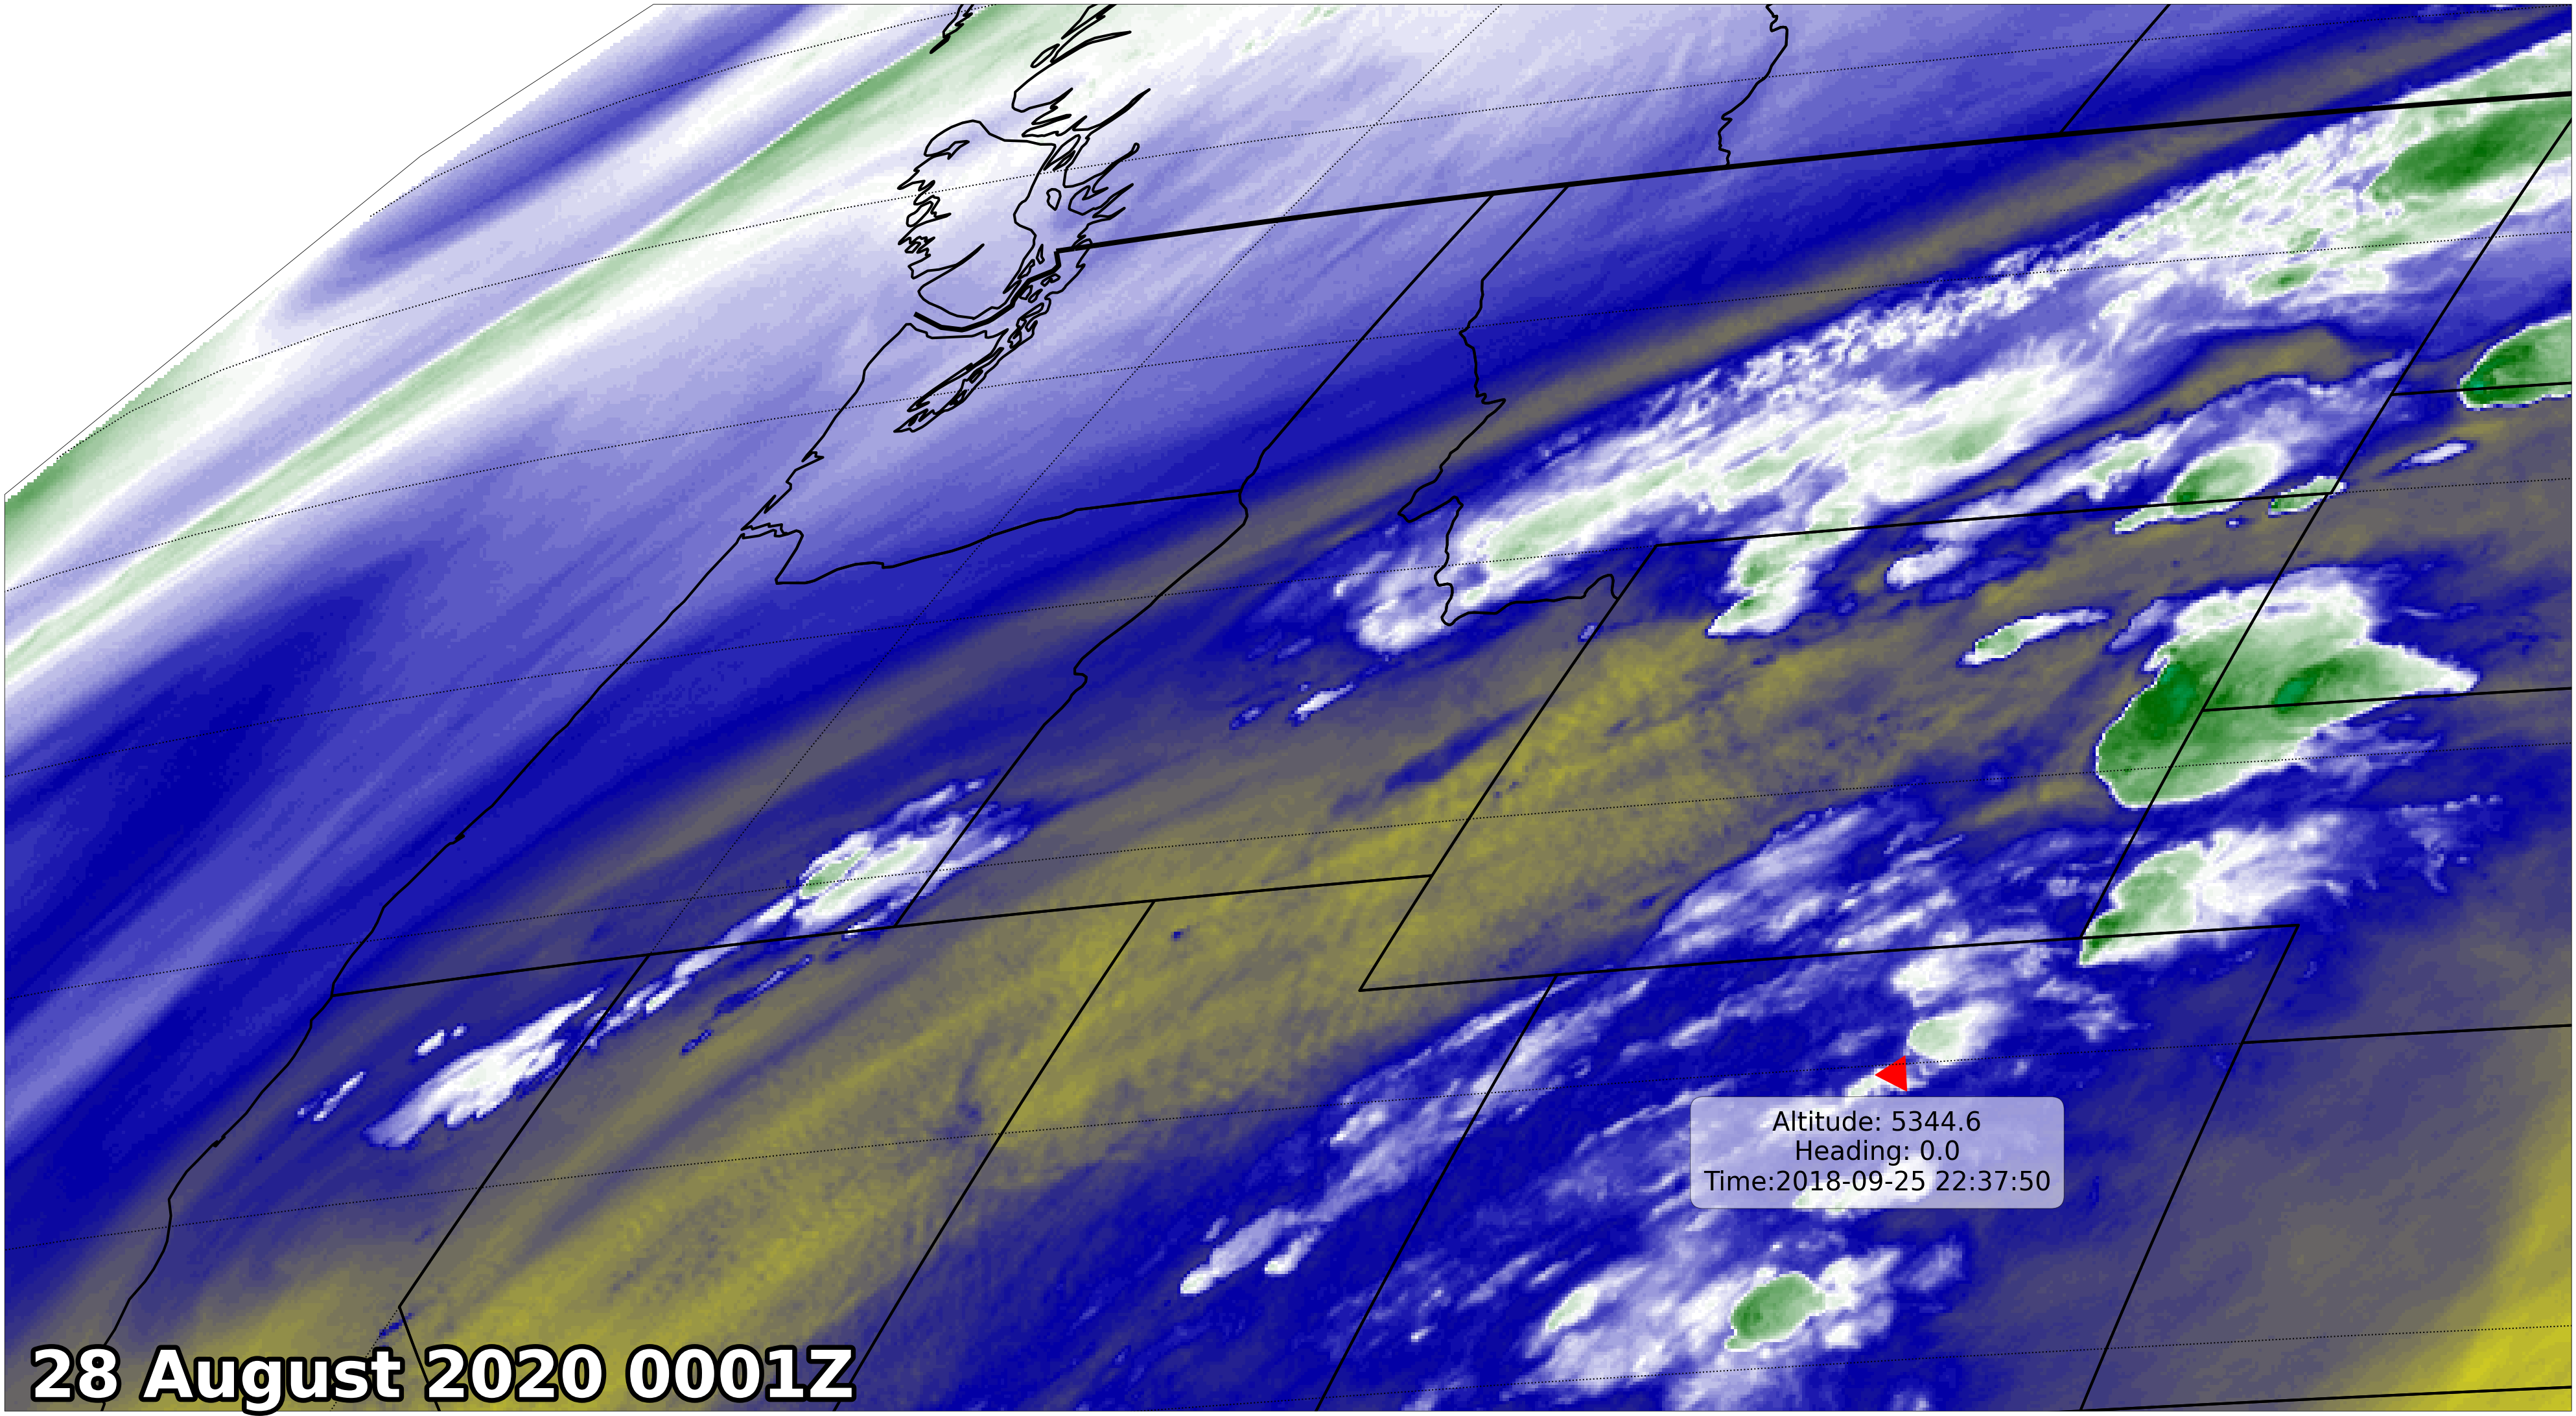

In [8]:
# Make the plot
fig = plt.figure(figsize=(1.375 * 40, 40))
ax = fig.add_subplot(1, 1, 1, projection=proj)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

wv_norm, wv_cmap = registry.get_with_range('WVCIMSS_r', 195, 265)

im = ax.imshow(dat, extent=(x.min(), x.max(), y.min(), y.max()),
               origin='upper')

im.set_cmap(wv_cmap)
im.set_norm(wv_norm)

ax.add_feature(cfeature.BORDERS, linewidth=8, edgecolor='black')
ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle='-',
               edgecolor='black', linewidth=4)

timestamp = datetime.strptime(ds.start_date_time, '%Y%j%H%M%S')

text_time = ax.text(0.01, 0.01, timestamp.strftime('%d %B %Y %H%MZ'),
                    horizontalalignment='left', transform=ax.transAxes,
                    color='white', fontsize=100, weight='bold')

outline_effect = [patheffects.withStroke(linewidth=15, foreground='black')]
text_time.set_path_effects(outline_effect)

ax.set_extent([-124.5, -105, 38.5, 50])

# Transform plane heading to a map direction and plot a rotated marker
u, v = mpcalc.wind_components(1 * units('m/s'),
                              data['heading'] * units('degrees'))
u, v = proj.transform_vectors(ccrs.PlateCarree(), np.array([data['longitude']]),
                              np.array([data['latitude']]), np.array([u.m]),
                              np.array([v.m]))
map_direction = -mpcalc.wind_direction(u * units.knots, v * units.knots).to('degrees')
map_direction = map_direction[0].m

ax.scatter(data['longitude'], data['latitude'],
           transform=ccrs.PlateCarree(),
           marker=(3, 0, map_direction),
           color='red',
           s=4000)

ax.text(data['longitude'], data['latitude'] - 0.3,
        'Altitude: {}\nHeading: {}\nTime:{}'.format(data['altitude'],
                                                    data['heading'],
                                                    data['time']),
        transform=ccrs.PlateCarree(), fontsize=40,
        ha='center', va='top',
        bbox={'facecolor': 'white', 'edgecolor': 'black',
              'boxstyle': 'round,pad=0.5', 'alpha': 0.6})

ax.gridlines(linestyle=':', color='black', linewidth=2)